In [17]:
from calibrator import *
#from analysis import *
from dobbel import *
import matplotlib.pyplot as plt
dob = dobbellogger()

In [57]:
import pandas as pd
import numpy as np
from help_functies import *
from matrix_helper import *


def run_analysis(data_df_or_csv_path, cali, std_cali, N, gamma, N_zv, gamma_zv, csv=False, firstlast=False, save_path='results.csv'):
    gyro_std = std_cali['gyro stds']
    acc_std = std_cali['acc stds']
    if csv:
        data_nb = pd.read_csv(data_df_or_csv_path)
    else:
        data_nb = data_df_or_csv_path.copy()
    data_nb = remove_nan(data_nb)
    rotmat, biasvec, gyro_bias = cali['acc rotmat'], cali['acc bias'], cali['gyro bias']
    data_nb['x_gyro'] = data_nb['x_gyro'] - gyro_bias[0]
    data_nb['y_gyro'] = data_nb['y_gyro'] - gyro_bias[1]
    data_nb['z_gyro'] = data_nb['z_gyro'] - gyro_bias[2]

    no_bias_list = []
    for i, row in data_nb.iterrows():
        meas = np.array([[row['x_acc']], [row['y_acc']], [row['z_acc']]])
        no_bias = np.matmul(rotmat, meas) + np.reshape(biasvec, (3, 1))
        no_bias_list.append(np.reshape(no_bias, 3))

    no_bias = np.reshape(np.concatenate(no_bias_list), (len(no_bias_list), 3))
    data_nb['x_acc'] = no_bias[:, 0]
    data_nb['y_acc'] = no_bias[:, 1]
    data_nb['z_acc'] = no_bias[:, 2]

    for i, row in data_nb.iterrows():
        data_nb.loc[i, 'x_gyro'], data_nb.loc[i, 'y_gyro'], data_nb.loc[i, 'z_gyro'] = rotate_vector(np.array([row['x_gyro'], row['y_gyro'], row['z_gyro']]), cali['rot quat gyro'])


    y11 = np.array([np.mean(data_nb['x_acc'][0:10]), np.mean(data_nb['y_acc'][0:10]), np.mean(data_nb['z_acc'][0:10])])
    gb = y11 / np.linalg.norm(y11)
    gn = np.array([0, 0, 1])
    mn = np.array([1, 0, 0])
    ymb= np.array([1, 2, 3])
    mb = np.array([1, 0, 0]) #np.cross(gb, np.cross(ymb / np.linalg.norm(ymb), gb))

    A = - np.matmul(left_quat_mul(np.array([0, *gn])), right_quat_mul(np.array([0, *gb]))) - np.matmul(left_quat_mul(np.array([0, *mn])), right_quat_mul(np.array([0, *mb])))

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(A)

    # Eigenvalues are sorted in ascending order by np.linalg.eigh,
    # and the corresponding eigenvectors are columns of 'eigenvectors'
    max_eigenvalue_index = np.argmax(eigenvalues)
    max_eigenvector = eigenvectors[:, max_eigenvalue_index]

    q11 = max_eigenvector

    dqde = np.array([
        [0,0,0],
        [1,0,0],
        [0,1,0],
        [0,0,1]
    ])

    sigma_etha = np.array([
        [(np.pi / 9) ** 2, 0, 0],
        [0, (np.pi / 9) ** 2, 0],
        [0, 0, (np.pi / 9) ** 2]
    ])

    P11_rot = 0.25 * np.matmul(np.matmul(np.matmul(np.matmul(right_quat_mul(q11), dqde), sigma_etha), dqde.T), right_quat_mul(q11))
    v11 = np.array([0,0,0])
    p11 = np.array([0,0,0])


    Q_gyro = np.array([
        [gyro_std[0] ** 2, 0, 0],
        [0, gyro_std[1] ** 2, 0],
        [0, 0, gyro_std[2] ** 2]
    ])
    Q_pv_std = 0.0001
    Q_pv = Q_pv_std * np.eye(6)
    Q = np.vstack([np.hstack([Q_pv, np.zeros((6, 3))]), np.hstack([np.zeros((3, 6)), Q_gyro])])

    small_R = 100 * np.array([
        [acc_std[0] ** 2, 0, 0],
        [0, acc_std[1] ** 2, 0],
        [0, 0, acc_std[2] ** 2],
    ])

    R_pzv_std = 0.0001
    R_pzv = R_pzv_std * np.eye(4)
    large_R = np.vstack([np.hstack([R_pzv, np.zeros((4, 3))]), np.hstack([np.zeros((3, 4)), small_R])])

    Ppvstd = 0
    P11 = np.vstack([np.hstack([Ppvstd * np.eye(6), np.zeros((6, 4))]), np.hstack([np.zeros((4, 6)), P11_rot])])


    zv_data = zv_checker(data_nb, N_zv, gamma_zv, firstlast)

    xtmin1tmin1 = np.concatenate([p11, v11, q11])
    Ptmin1tmin1 = P11

    x_list = [xtmin1tmin1]
    epsilon_list = []
    ygnrot_list = []
    yab_list = []

    K_list = []
    P_list = []
    an_list = []

    for i in range(1, len(zv_data['timestamp'])):
        dt = (zv_data['timestamp'][i] - zv_data['timestamp'][i - 1]) / 1000
        gyro_measurement = np.array([zv_data['x_gyro'][i], zv_data['y_gyro'][i], zv_data['z_gyro'][i]])
        omega = gyro_measurement
        expq_omega = expq(omega, 0.5 * dt * np.pi / 180)

        ptmin1tmin1 = xtmin1tmin1[:3]
        vtmin1tmin1 = xtmin1tmin1[3:6]
        qtmin1tmin1 = xtmin1tmin1[6:]

        yat_b = np.array([zv_data['x_acc'][i], zv_data['y_acc'][i], zv_data['z_acc'][i]])
        yat_n = rotate_vector(gn, quaternion_conjugate(np.reshape(qtmin1tmin1, 4)))
        ygnrot_list.append(yat_n)
        yab_list.append(yat_b)

        an = rotate_vector(yat_b, np.reshape(qtmin1tmin1, 4)) - gn
        an_list.append(an)

        pttmin1 = ptmin1tmin1 + dt * vtmin1tmin1 + 0.5 * an * 9.81 * dt ** 2
        vttmin1 = vtmin1tmin1 + dt * an * 9.81
        qttmin1 = quat_mul(qtmin1tmin1, expq_omega)
        xttmin1 = np.concatenate([pttmin1, vttmin1, qttmin1])

        Ftmin1 = calculate_F(xttmin1, omega, yat_b * 9.81, dt)
        Gtmin1 = calculate_G(xttmin1, dt)
        Pttmin1 = np.matmul(np.matmul(Ftmin1, Ptmin1tmin1), Ftmin1.T) + np.matmul(np.matmul(Gtmin1, Q), Gtmin1.T)
        P_list.append(Ptmin1tmin1)
        if zv_data['zero velocity'][i]:
            H = calculate_large_H(xttmin1)
            S = np.matmul(np.matmul(H, Pttmin1), H.T) + large_R
            K = np.matmul(np.matmul(Pttmin1, H.T), np.linalg.inv(S))
            yateps_rot = yat_b / np.linalg.norm(yat_b)
            yattmin1_rot = rotate_vector(gn, quaternion_conjugate(np.reshape(qttmin1, 4)))
            epsilon_rot = yateps_rot - yattmin1_rot
            ypzv_est = np.array([pttmin1[2], *vttmin1])
            ypzv_mea = np.zeros(4)
            epsilon_pos = np.reshape(ypzv_mea - ypzv_est, (4, 1))
            epsilon = np.vstack([epsilon_pos, np.reshape(epsilon_rot, (3, 1))])
            x_tt_measure = np.reshape(xttmin1, (10, 1)) + np.matmul(K, epsilon)
        else:
            H = calculate_small_H(xttmin1)
            S = np.matmul(np.matmul(H, Pttmin1), H.T) + small_R
            K = np.matmul(np.matmul(Pttmin1, H.T), np.linalg.inv(S))

            K_list.append(K)

            yateps = yat_b / np.linalg.norm(yat_b)
            yattmin1 = rotate_vector(gn, quaternion_conjugate(np.reshape(qttmin1, 4)))
            epsilon = np.reshape(yateps - yattmin1, (3, 1))
            x_tt_measure = np.reshape(xttmin1, (10, 1)) + np.matmul(K, epsilon)

        epsilon_list.append(epsilon)

        Ptt = Pttmin1 - np.matmul(np.matmul(K, H), Pttmin1)
        x_tt_measure = np.reshape(x_tt_measure, 10)
        x_tt = np.concatenate([x_tt_measure[:6], x_tt_measure[6:] / np.linalg.norm(x_tt_measure[6:])])

        Ptmin1tmin1 = Ptt
        xtmin1tmin1 = x_tt
        x_list.append(x_tt)

    x_array = np.reshape(np.concatenate(x_list), (len(x_list), 10))
    kalman_results = pd.DataFrame(x_array, columns=['px', 'py', 'pz', 'vx', 'vy', 'vz', 'q0', 'q1', 'q2', 'q3'])


    quat_data = np.array([kalman_results['q0'], kalman_results['q1'], kalman_results['q2'], kalman_results['q3']]).T
    euler_data = np.zeros((quat_data.shape[0], 3))

    for i, q in enumerate(quat_data):
        euler_data[i] = quat_to_euler_tan2(q)
    euler_df = pd.DataFrame(euler_data, columns=['psi', 'theta', 'phi'])

    luchttijd = []
    gooitijd = []

    # Oprapen na stilstand op grond
    verg_data = zv_data.copy().drop('zero velocity', axis=1) - zv_data.iloc[0, :-1]
    gooi_data = zv_data.copy().drop('zero velocity', axis=1)

    gooi_data['squared norm'] = verg_data['x_acc'] ** 2 + verg_data['y_acc'] ** 2 + verg_data['z_acc'] ** 2

    # Zero acceleration na loslaten
    za_data = zv_data.copy()
    za_data['squared norm'] = zv_data['x_acc'] ** 2 + zv_data['y_acc'] ** 2 + zv_data['z_acc'] ** 2

    total_raap_duration = 0
    total_lucht_duration = 0
    total_gooi_duration = 0

    while gamma < 0.1:
        done = False
        gedaan = False
        luchttijd.clear()
        gooitijd.clear()

        for i in range(N, len(za_data) - N):
            # Herken wanneer dobbelsteen wanneer wordt opgepakt
            if all(waarde > 0.1 * gamma for waarde in gooi_data['squared norm'][i - N:i + N]) and not gedaan:
                gooitijd.append(zv_data['timestamp'][i])
                gedaan = True
                total_raap_duration = gooitijd[-1] - 2 * N

            # Herken wanneer dobbelsteen de hand verlaat
            elif all(element < gamma for element in za_data['squared norm'][i - N:i + N]):
                temp_luchttijd = list(zv_data['timestamp'][i - N:i + N])

                # Randvoorwaarde dat de dobbelsteen minstens 0.5 secondes wordt geschud
                if gooitijd and (temp_luchttijd[0] - gooitijd[-1]) > 500:
                    luchttijd.extend(temp_luchttijd)

                    # Continue adding timestamps while in the air
                    for j in range(i + N, len(za_data)):
                        if za_data['squared norm'][j] < gamma:
                            luchttijd.append(zv_data['timestamp'][j])
                        else:
                            # Stop adding when a hard landing is detected
                            if za_data['squared norm'][j] > 10 * gamma:  # A large spike indicating a hard landing
                                break
                            luchttijd.append(zv_data['timestamp'][j])

                    gooitijd = sorted(gooitijd)
                    luchttijd = sorted(luchttijd)

                    # if gooitijd:
                    #     total_raap_duration = gooitijd[-1] - 2 * N

                    if luchttijd:
                        land_tijd = luchttijd[-1]
                        los_tijd = luchttijd[0]
                        total_lucht_duration = land_tijd - los_tijd

                    if gooitijd and luchttijd:
                        total_gooi_duration = los_tijd - total_raap_duration
                    done = True
                    break

        if done:
            break

        gamma += 0.005
        # print(gamma)
        if gamma > 0.5:
            print("onzeker")
            break

    total_starttotlos = total_raap_duration + total_gooi_duration
    total_starttotgrond = total_lucht_duration + total_raap_duration + total_gooi_duration

    side = side_detector(np.mean(np.array([data_nb.loc[len(data_nb)-11:, 'x_acc'], data_nb.loc[len(data_nb)-11:, 'y_acc'], data_nb.loc[len(data_nb)-11:, 'z_acc']]).T, axis=0))

    zero_acc_results = np.array([[total_raap_duration], [total_gooi_duration], [total_lucht_duration], [total_starttotlos], [total_starttotgrond], [side]]).T
    zero_acc_df = pd.DataFrame(zero_acc_results, columns=['Raap tijd', 'Gooi tijd', 'Lucht tijd', 'Start tot los', 'Start tot grond', 'Laatste zijde'])
    
    results = pd.concat([zv_data, kalman_results, euler_df, zero_acc_df], axis=1)
    
    raap_index = results[results.loc[:, 'timestamp'] == results.loc[0, 'Gooi tijd']].index
    loslaat_index = results[results.loc[:, 'timestamp'] == results.loc[0, 'Start tot los']].index
    neerkom_index = results[results.loc[:, 'timestamp'] == results.loc[0, 'Start tot grond']].index
    
    for i in range(len(results) - 2 - N_zv, N_zv, -1):
        if not results.loc[i, 'zero velocity']:
            stillig_index = i + 1
            break
    
    an_arr = np.reshape(np.concatenate(an_list), (len(an_list), 3))
    norm_acc = np.linalg.norm(an_arr, axis=1)
    
    mean_acc_hand = np.mean(norm_acc[raap_index[0] : loslaat_index[0]])
    mean_acc_roll = np.mean(norm_acc[neerkom_index[0] : stillig_index])
    
    mean_acc_df = pd.DataFrame(np.array([[mean_acc_hand, mean_acc_roll]]), columns=['Mean acc hand', 'Mean acc roll'])
    results = pd.concat([results, mean_acc_df], axis=1)
    
    if csv:
        results.to_csv(save_path)
    else:
        return results

In [33]:
test = pd.DataFrame({
    'A': [True, False, False, True, True]
})

print(list(test[test.loc[:, 'A']].index))

[0, 3, 4]


In [52]:
for value in results.loc[:, 'zero velocity']:
    print(value)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [19]:
lijst1 = []
lijst2 = []
lijst3 = []
lijst4 = []

for column, sign, side in [(2, 1, 1), (0, 1, 2), (1, 1, 3), (1, -1, 4), (0, -1, 5), (2, -1, 6)]:
    lijst1, lijst2, lijst3, lijst4 = cali_loop(column, sign, side, dob, 1, 1, 100, 2, 125, lijst1, lijst2, lijst3, lijst4)
    
cali = calibrate_rot_bias(lijst1, lijst2, lijst3, lijst4)

Leg de dobbelsteen met nummer  1  boven
Wacht 1 secondes
Logging data for 1s
Done! The data is located in self.datadf
Leg de dobbelsteen met nummer  2  boven
Wacht 1 secondes
Logging data for 1s
Done! The data is located in self.datadf
Leg de dobbelsteen met nummer  3  boven
Wacht 1 secondes
Logging data for 1s
Done! The data is located in self.datadf
Leg de dobbelsteen met nummer  4  boven
Wacht 1 secondes
Logging data for 1s
Done! The data is located in self.datadf
Leg de dobbelsteen met nummer  5  boven
Wacht 1 secondes
Logging data for 1s
Done! The data is located in self.datadf
Leg de dobbelsteen met nummer  6  boven
Wacht 1 secondes
Logging data for 1s
Done! The data is located in self.datadf


In [20]:
std_cali = cali_std(dob, 3, 400, 125)

Leg de dobbelsteen stil
Logging data for 3s
Done! The data is located in self.datadf


In [21]:
dob.connect()
dob.log(5, 400, 4, 500)
dob.download()
data = dob.datadf

Logging data for 5s
Done! The data is located in self.datadf


In [58]:
results = run_analysis(data, cali, std_cali, N=10, gamma=0.005, N_zv=5, gamma_zv=0.05)
total_raap_duration = results.loc[0, 'Raap tijd']
total_gooi_duration = results.loc[0, 'Gooi tijd']
total_lucht_duration = results.loc[0, 'Lucht tijd']
start_tot_loslaten = results.loc[0, 'Start tot los']
start_tot_grond = results.loc[0, 'Start tot grond']
laatste_zijde = results.loc[0, 'Laatste zijde']
print("Dobbel tijd oprapen = ", total_raap_duration)
print("Dobbel tijd van oprapen tot loslaten = ", total_gooi_duration)
print("Dobbel tijd in de lucht = ", total_lucht_duration)
print("Dobbel tijd tot loslaten vanaf begin programma = ", start_tot_loslaten)
print("Zijde omhoog = ", laatste_zijde)
results.head()

Dobbel tijd oprapen =  1099.0
Dobbel tijd van oprapen tot loslaten =  1063.0
Dobbel tijd in de lucht =  130.0
Dobbel tijd tot loslaten vanaf begin programma =  2162.0
Zijde omhoog =  2.0


,timestamp,x_acc,y_acc,z_acc,x_gyro,y_gyro,z_gyro,squared norm,zero velocity,px,...,theta,phi,Raap tijd,Gooi tijd,Lucht tijd,Start tot los,Start tot grond,Laatste zijde,Mean acc hand,Mean acc roll
0,0.0,-0.014791,-0.001652,-0.969334,-0.211503,0.510002,0.865756,1.054370,False,0.000000,...,-0.006999,3.141029,1099.0,1063.0,130.0,2162.0,2292.0,2.0,0.788619,0.989389
1,31.0,-0.015780,-0.001234,-0.971328,-0.389145,-0.298560,0.125715,0.256376,False,-0.000072,...,-0.007109,3.141265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,32.0,-0.012456,-0.001668,-0.967063,-0.253415,-0.219798,0.050308,0.115061,False,-0.000077,...,-0.007112,3.141269,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,34.0,-0.012678,-0.001910,-0.963726,0.018044,-0.062274,-0.100507,0.014305,False,-0.000086,...,-0.007115,3.141268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,35.0,-0.012789,-0.002030,-0.962058,0.202267,-0.105323,0.012522,0.052162,False,-0.000091,...,-0.007117,3.141265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


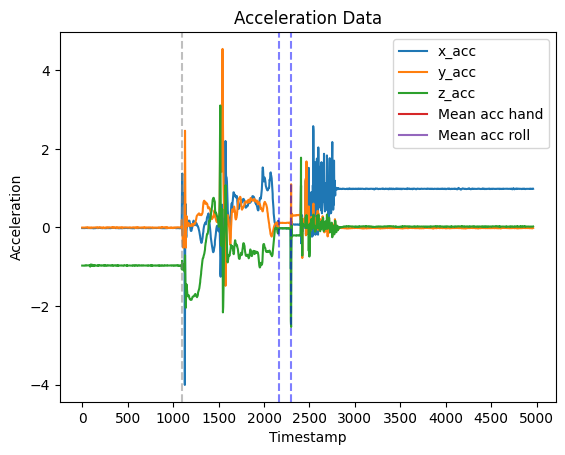

In [31]:
# Assume data is already defined
df = results

# Plot the accelerometer values
columns_to_plot = [col for col in df.columns if 'acc' in col]
df.plot(x='timestamp', y=columns_to_plot, kind='line')

# Vertical gray line for when the dice is picked up
plt.axvline(x=total_raap_duration, color='gray', linestyle='--', alpha=0.5, label='Start to Pickup')

# Vertical red line for when the dice leaves the hand
plt.axvline(x=start_tot_loslaten, color='blue', linestyle='--', alpha=0.5, label='Start to Release')

# Vertical blue line for when the dice hits the ground
plt.axvline(x=start_tot_grond, color='blue', linestyle='--', alpha=0.5, label='Start to Ground')

# Set labels and title
plt.xlabel('Timestamp')
plt.ylabel('Acceleration')
plt.title('Acceleration Data')

# Set x-axis grid with a spacing of 500 units
plt.xticks(range(int(df['timestamp'].min()), int(df['timestamp'].max()) + 500, 500))

# Show the plot
plt.show()

In [15]:
dob.disconnect()

we are disconnected!
